In [24]:
'''Import packages for loading data, analysing, and plotting'''

import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import warnings
#warnings.filterwarnings("ignore")
#import iris
#from iris import load, Constraint
#import iris.quickplot as qplt
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
#from mpl_toolkits.basemap import Basemap
#from mpl_toolkits import basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
#import xlrd
import os
import matplotlib.colors as colors
#from matplotlib.mlab import bivariate_normal

In [25]:
 #No change needs here

'''Define CMIP list'''


cmip6=['IPSL-CM6A-LR',
       'HadGEM3-GC31',
       'AWI-ESM']

cmip5=['GISS-E2-1-G',
     'COSMOS-ASO',
     'MRI-CGCM3',
     'CNRM-CM5',
     'FGOALS-g2',
     'GISS-E2-R',
     'EC-EARTH-2-2',
     'IPSL-CM5A-LR',
     'bcc-csm1-1',
     'HadGEM2-CC',
     'HadCM3',
     'MPI-ESM-P',
     'CCSM4',
     'CSIRO-Mk3L-1-2',
     'CSIRO-Mk3-6-0',
     'FGOALS-s2',
     'MIROC-ESM']
cmip_all=['GISS-E2-1-G',
 'COSMOS-ASO',
 'AWI-ESM',
 'MRI-CGCM3',
 'CNRM-CM5',
 'FGOALS-g2',
 'GISS-E2-R',
 'EC-EARTH-2-2',
 'IPSL-CM5A-LR',
 'IPSL-CM6A-LR',
 'bcc-csm1-1',
 'HadGEM3-GC31',
 'HadGEM2-CC',
 'HadCM3',
 'MPI-ESM-P',
 'CCSM4',
 'CSIRO-Mk3L-1-2',
 'CSIRO-Mk3-6-0',
 'FGOALS-s2',
 'MIROC-ESM']

cmip={}
cmip['CMIP5']=cmip5
cmip['CMIP6']=cmip6
cmip['CMIP']=cmip_all

cmip_v5='CMIP5'
cmip_v6='CMIP6'

In [52]:
#No change needs here

'''Define functions'''

#This function will get all available experiment names
def experimentlist():
    exps=[]
    file_path = "data" 
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for d in dirnames:
            exps.append(d)
    return exps

#This function will get all available model names in the experiment 
def modellist(experiment_name):
    models=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, filenames in os.walk(file_path):
        for f in filenames:
            mname=f.split("_")[0]
            models.append(mname)
    return models

#This function will get all available filenames in the experiment 
def filenamelist(experiment_name):
    filenames=[]
    file_path = "data/%s" %(experiment_name)
    for dirpaths, dirnames, files in os.walk(file_path):
        for f in files:
            ff='data/%s/%s'%(experiment_name,f)
            filenames.append(ff)
    return filenames


def identify_ensemble_members(variable_name,experiment_name):
    datadir="data/%s" %(experiment_name)
    ensemble_members=!scripts/find_experiment_ensemble_members.bash {experiment_name} {variable_name} {datadir}
    return ensemble_members

def extract_model_name(filename):
    file_no_path=filename.rpartition("/")
    file_strings=file_no_path[2].partition("_")
    model_name=file_strings[0]
    return model_name

def ensemble_members_dict(variable_name,experiment_name):
    ens_mems=identify_ensemble_members(variable_name,experiment_name)
    ens_mems_dict={extract_model_name(ens_mems[0]):ens_mems[0]}
    for mem in ens_mems[1:]:
        ens_mems_dict[extract_model_name(mem)]=mem
    return ens_mems_dict
    
def ensemble_mean(cmip_v):
    n=0
    average=0
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-0, 360, 1.0))})
    gcm_dict=ensemble_members_dict(variable_name,experiment_name)
    for gcm in gcm_dict:
        if gcm in cmip[cmip_v]:
            this_file=xr.open_dataset(gcm_dict.get(gcm),decode_times=False)
            this_var=this_file[variable_name]
            this_regridder=xe.Regridder(this_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
            var_1x1=this_regridder(this_var)
            average=(n*average+var_1x1)/(n+1)
            n=n+1
    return average


def ensemble_mean_diffence(cmip_v):
    n=0
    average=0
    A_dict=ensemble_members_dict(variable_name,experiment_name)
    B_dict=ensemble_members_dict(variable_name,'piControl')
    grid_1x1= xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-0, 360., 1.0))})
    for gcm in A_dict:
        if gcm in B_dict:
            if gcm in cmip[cmip_v]:
                expt_a_file=xr.open_dataset(A_dict.get(gcm),decode_times=False)
                expt_a=expt_a_file[variable_name]
                expt_b_file=xr.open_dataset(B_dict.get(gcm),decode_times=False)
                expt_b=expt_b_file[variable_name]
                diff=expt_a-expt_b
                this_regridder=xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=True,periodic=True) 
                diff_1x1=this_regridder(diff)
                average=(n*average+diff_1x1)/(n+1)
                n=n+1
    return average

In [53]:
experiment_name='midHolocene'
variable_name='tas_spatialmean_ann'
cmip_v='CMIP6'

In [54]:

ensemble_average=ensemble_mean(cmip_v)
ensemble_diff=ensemble_mean_diffence(cmip_v)



Create weight file: bilinear_96x192_180x360_peri.nc
Create weight file: bilinear_144x192_180x360_peri.nc
Create weight file: bilinear_143x144_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_144x192_180x360_peri.nc
Reuse existing file: bilinear_143x144_180x360_peri.nc


In [57]:
ensemble_diff_r=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r[r][c]=ensemble_diff[r][c-180]

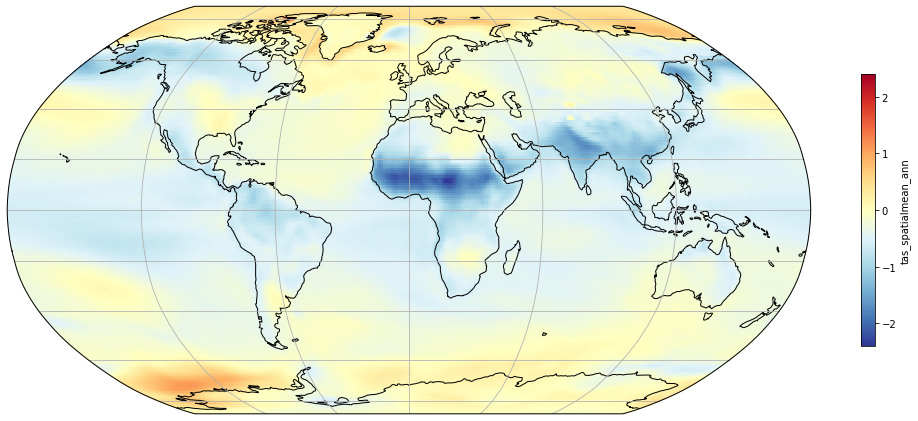

In [56]:
cmap=plt.get_cmap('RdYlBu_r')

fig = plt.figure(figsize=(18,10))
#title= '%s ensemble mean of changes in %s (%s - piControl)' %(cmip_v,variable_name,experiment_name)

ax = plt.axes(projection=ccrs.Robinson())
#ax.set_title(title)
ax.coastlines()
ax.gridlines()
ensemble_diff.plot(ax=ax, transform=ccrs.PlateCarree(),cbar_kwargs={'shrink': 0.5},cmap=cmap)



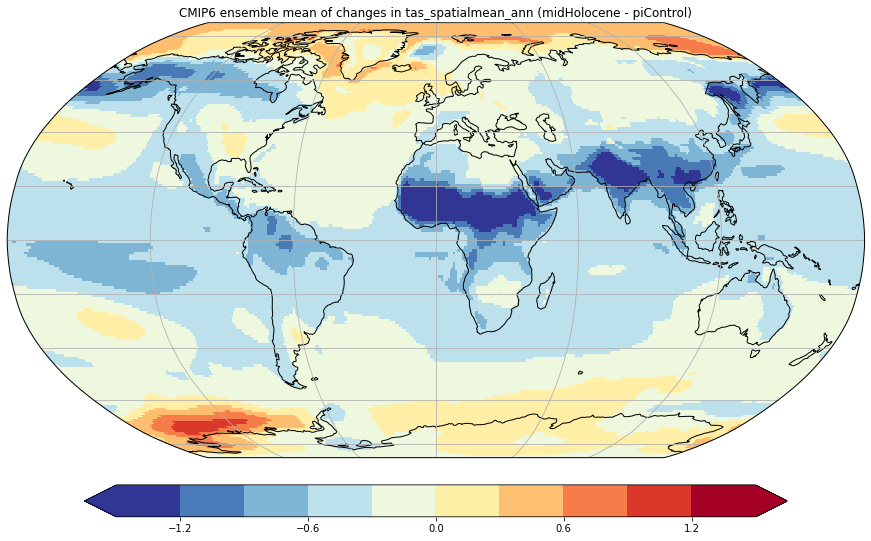

In [58]:
cmap=plt.get_cmap('RdYlBu_r')
clim=[-1.5,1.5]
bounds = np.linspace(-1.5, 1.5, 11)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)



plt.figure(figsize=(18,10))

title= '%s ensemble mean of changes in %s (%s - piControl)' %(cmip_v,variable_name,experiment_name)

ax = plt.axes(projection=ccrs.Robinson())
plt.title(title)
ax.coastlines()
ax.gridlines()
fig=ax.imshow(ensemble_diff_r, transform=ccrs.PlateCarree(),cmap=cmap,clim=clim,norm=norm)
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,shrink=0.7)
plt.colorbar(fig,cax=cax,extend='both',**kw)



## 2. Multi plots (CMIP6, CMIP5, CMIP6-CMIP5)

### tas_spatialmean_ann

In [59]:
experiment_name='midHolocene'
variable_name='tas_spatialmean_ann'


In [60]:
ensemble_average_v5=ensemble_mean(cmip_v5)
ensemble_diff_v5=ensemble_mean_diffence(cmip_v5)
ensemble_average_v6=ensemble_mean(cmip_v6)
ensemble_diff_v6=ensemble_mean_diffence(cmip_v6)

ensemble_diff_v=ensemble_diff_v6-ensemble_diff_v5

ensemble_diff_r_v6=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r_v6[r][c]=ensemble_diff_v6[r][c-180]
        
ensemble_diff_r_v5=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r_v5[r][c]=ensemble_diff_v5[r][c-180]
        
ensemble_diff_r_v=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r_v[r][c]=ensemble_diff_v[r][c-180]



Create weight file: bilinear_192x288_180x360_peri.nc
Create weight file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Create weight file: bilinear_56x64_180x360_peri.nc
Create weight file: bilinear_160x320_180x360_peri.nc
Create weight file: bilinear_60x128_180x360_peri.nc
Create weight file: bilinear_108x128_180x360_peri.nc
Create weight file: bilinear_90x144_180x360_peri.nc
Create weight file: bilinear_145x192_180x360_peri.nc
Create weight file: bilinear_96x96_180x360_peri.nc
Create weight file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.

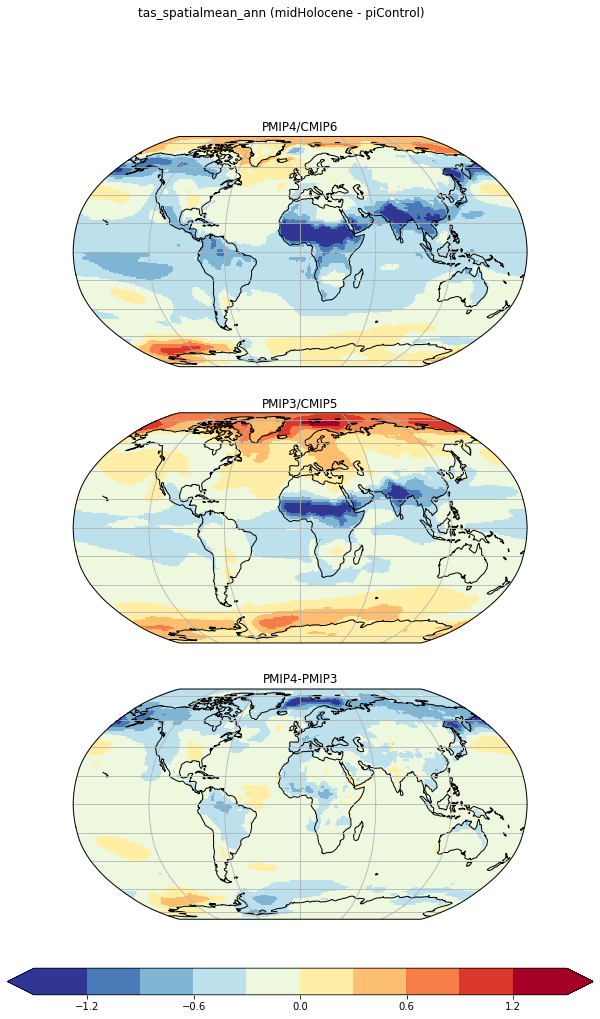

In [63]:
cmap=plt.get_cmap('RdYlBu_r')
projection = ccrs.Robinson()
transform=ccrs.PlateCarree()
clim=[-1.5,1.5]
bounds = np.linspace(-1.5, 1.5, 11)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(21, 18), subplot_kw={'projection': ccrs.Robinson()})

ax1=axs[0]
ax2=axs[1]
ax3=axs[2]


title= '%s (%s - piControl)' %(variable_name,experiment_name)
fig.suptitle(title)

#ax1 = plt.subplot(311, projection=projection)
ax1.set_title('PMIP4/CMIP6')
ax1.coastlines()
ax1.gridlines()
fig1=ax1.imshow(ensemble_diff_r_v6, transform=transform,cmap=cmap,clim=clim,norm=norm)



#ax2 = plt.subplot(312, projection=projection)
ax2.set_title('PMIP3/CMIP5')
ax2.coastlines()
ax2.gridlines()
fig2=ax2.imshow(ensemble_diff_r_v5, transform=transform,cmap=cmap,clim=clim,norm=norm)

#ax3 = plt.subplot(313, projection=projection)
ax3.set_title('PMIP4-PMIP3')
ax3.coastlines()
ax3.gridlines()
fig3=ax3.imshow(ensemble_diff_r_v, transform=transform,cmap=cmap,clim=clim,norm=norm)


cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
plt.colorbar(fig3, cax=cax, **kw,extend='both')

plt.show()

### tas_spatialstddev_ann

In [64]:
experiment_name='midHolocene'
variable_name='tas_spatialstddev_ann'


In [ ]:

ensemble_average_v5=ensemble_mean(cmip_v5)
ensemble_diff_v5=ensemble_mean_diffence(cmip_v5)
ensemble_average_v6=ensemble_mean(cmip_v6)
ensemble_diff_v6=ensemble_mean_diffence(cmip_v6)

ensemble_diff_v=ensemble_diff_v6-ensemble_diff_v5

ensemble_diff_r_v6=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r_v6[r][c]=ensemble_diff_v6[r][c-180]
        
ensemble_diff_r_v5=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r_v5[r][c]=ensemble_diff_v5[r][c-180]
        
ensemble_diff_r_v=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r_v[r][c]=ensemble_diff_v[r][c-180]


Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_60x128_180x360_peri.nc
Reuse existing file: bilinear_108x128_180x360_peri.nc
Reuse existing file: bilinear_90x144_180x360_peri.nc
Reuse existing file: bilinear_145x192_180x360_peri.nc
Reuse existing file: bilinear_96x96_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_160x320_180x360_peri.nc
Reuse existing file: bilinear_64x128_180x360_peri.nc
Reuse existing file: bilinear_192x288_180x360_peri.nc
Reuse existing file: bilinear_128x256_180x360_peri.nc
Reuse existing file: bilinear_96x192_180x360_peri.nc
Reuse existing file: bilinear_56x64_180x360_peri.nc
Reuse existing file: bilinear_160x320_180

In [ ]:
cmap=plt.get_cmap('YlOrRd')
projection = ccrs.Robinson()
transform=ccrs.PlateCarree()
clim=[0,0.3]
bounds = np.linspace(0, 0.3, 11)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(21, 18), subplot_kw={'projection': ccrs.Robinson()})

ax1=axs[0]
ax2=axs[1]
ax3=axs[2]


title= '%s (%s - piControl)' %(variable_name,experiment_name)
fig.suptitle(title)

#ax1 = plt.subplot(311, projection=projection)
ax1.set_title('PMIP4/CMIP6')
ax1.coastlines()
ax1.gridlines()
fig1=ax1.imshow(ensemble_diff_r_v6, transform=transform,cmap=cmap,clim=clim,norm=norm)



#ax2 = plt.subplot(312, projection=projection)
ax2.set_title('PMIP3/CMIP5')
ax2.coastlines()
ax2.gridlines()
fig2=ax2.imshow(ensemble_diff_r_v5, transform=transform,cmap=cmap,clim=clim,norm=norm)

#ax3 = plt.subplot(313, projection=projection)
ax3.set_title('PMIP4-PMIP3')
ax3.coastlines()
ax3.gridlines()
fig3=ax3.imshow(ensemble_diff_r_v, transform=transform,cmap=cmap,clim=clim,norm=norm)


cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
plt.colorbar(fig3, cax=cax, **kw,extend='both')

plt.show()

### pr_spatialmean_ann

In [60]:
experiment_name='midHolocene'
variable_name='pr_spatialmean_ann'

In [61]:
ensemble_average_v5=ensemble_mean(cmip_v5)
ensemble_diff_v5=ensemble_mean_diffence(cmip_v5)
ensemble_average_v6=ensemble_mean(cmip_v6)
ensemble_diff_v6=ensemble_mean_diffence(cmip_v6)

ensemble_diff_v=ensemble_diff_v6-ensemble_diff_v5

ensemble_diff_r_v6=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r_v6[r][c]=ensemble_diff_v6[r][c-180]
        
ensemble_diff_r_v5=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r_v5[r][c]=ensemble_diff_v5[r][c-180]
        
ensemble_diff_r_v=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r_v[r][c]=ensemble_diff_v[r][c-180]



Reuse existing file: bilinear_192x288_180x360.nc
Reuse existing file: bilinear_128x256_180x360.nc
Reuse existing file: bilinear_96x192_180x360.nc
Reuse existing file: bilinear_56x64_180x360.nc
Reuse existing file: bilinear_160x320_180x360.nc
Reuse existing file: bilinear_60x128_180x360.nc
Reuse existing file: bilinear_108x128_180x360.nc
Reuse existing file: bilinear_90x144_180x360.nc
Reuse existing file: bilinear_145x192_180x360.nc
Reuse existing file: bilinear_96x96_180x360.nc
Reuse existing file: bilinear_64x128_180x360.nc
Reuse existing file: bilinear_96x192_180x360.nc
Reuse existing file: bilinear_160x320_180x360.nc
Reuse existing file: bilinear_64x128_180x360.nc
Reuse existing file: bilinear_192x288_180x360.nc
Reuse existing file: bilinear_128x256_180x360.nc
Reuse existing file: bilinear_96x192_180x360.nc
Reuse existing file: bilinear_56x64_180x360.nc
Reuse existing file: bilinear_160x320_180x360.nc
Reuse existing file: bilinear_60x128_180x360.nc
Reuse existing file: bilinear_108x

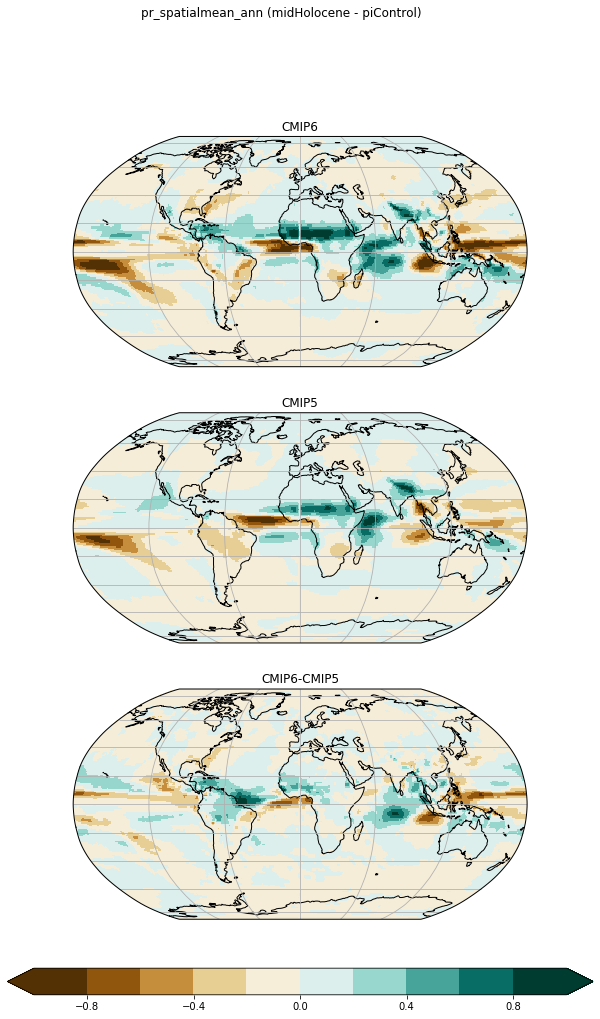

In [62]:
cmap=plt.get_cmap('BrBG')
projection = ccrs.Robinson()
transform=ccrs.PlateCarree()
clim=[-1,1]
bounds = np.linspace(-1, 1, 11)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(21, 18), subplot_kw={'projection': ccrs.Robinson()})

ax1=axs[0]
ax2=axs[1]
ax3=axs[2]


#ax1 = plt.subplot(311, projection=projection)
ax1.set_title('PMIP4/CMIP6')
ax1.coastlines()
ax1.gridlines()
fig1=ax1.imshow(ensemble_diff_r_v6, transform=transform,cmap=cmap,clim=clim,norm=norm)



#ax2 = plt.subplot(312, projection=projection)
ax2.set_title('PMIP3/CMIP5')
ax2.coastlines()
ax2.gridlines()
fig2=ax2.imshow(ensemble_diff_r_v5, transform=transform,cmap=cmap,clim=clim,norm=norm)

#ax3 = plt.subplot(313, projection=projection)
ax3.set_title('PMIP4-PMIP3')
ax3.coastlines()
ax3.gridlines()
fig3=ax3.imshow(ensemble_diff_r_v, transform=transform,cmap=cmap,clim=clim,norm=norm)


cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
plt.colorbar(fig3, cax=cax, **kw,extend='both')

plt.show()

### pr_spatialstddev_ann

In [63]:
experiment_name='midHolocene'
variable_name='pr_spatialstddev_ann'

In [64]:
ensemble_average_v5=ensemble_mean(cmip_v5)
ensemble_diff_v5=ensemble_mean_diffence(cmip_v5)
ensemble_average_v6=ensemble_mean(cmip_v6)
ensemble_diff_v6=ensemble_mean_diffence(cmip_v6)

ensemble_diff_v=ensemble_diff_v6-ensemble_diff_v5

ensemble_diff_r_v6=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r_v6[r][c]=ensemble_diff_v6[r][c-180]
        
ensemble_diff_r_v5=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r_v5[r][c]=ensemble_diff_v5[r][c-180]
        
ensemble_diff_r_v=np.zeros((180,360))

for r in range(180):
    for c in range(360):
        ensemble_diff_r_v[r][c]=ensemble_diff_v[r][c-180]




Reuse existing file: bilinear_192x288_180x360.nc
Reuse existing file: bilinear_128x256_180x360.nc
Reuse existing file: bilinear_96x192_180x360.nc
Reuse existing file: bilinear_56x64_180x360.nc
Reuse existing file: bilinear_160x320_180x360.nc
Reuse existing file: bilinear_60x128_180x360.nc
Reuse existing file: bilinear_108x128_180x360.nc
Reuse existing file: bilinear_90x144_180x360.nc
Reuse existing file: bilinear_145x192_180x360.nc
Reuse existing file: bilinear_96x96_180x360.nc
Reuse existing file: bilinear_64x128_180x360.nc
Reuse existing file: bilinear_96x192_180x360.nc
Reuse existing file: bilinear_160x320_180x360.nc
Reuse existing file: bilinear_64x128_180x360.nc
Reuse existing file: bilinear_192x288_180x360.nc
Reuse existing file: bilinear_128x256_180x360.nc
Reuse existing file: bilinear_96x192_180x360.nc
Reuse existing file: bilinear_56x64_180x360.nc
Reuse existing file: bilinear_160x320_180x360.nc
Reuse existing file: bilinear_60x128_180x360.nc
Reuse existing file: bilinear_108x

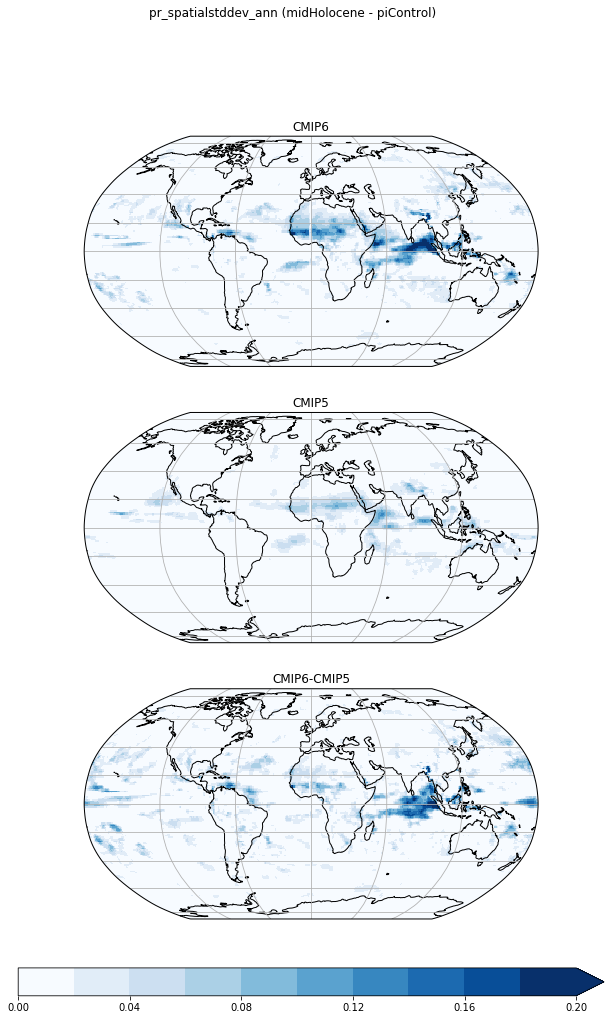

In [68]:
cmap=plt.get_cmap('Blues')
projection = ccrs.Robinson()
transform=ccrs.PlateCarree()
clim=[0,0.2]
bounds = np.linspace(0, 0.2, 11)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

fig, axs = plt.subplots(nrows=3,ncols=1,figsize=(21, 18), subplot_kw={'projection': ccrs.Robinson()})

ax1=axs[0]
ax2=axs[1]
ax3=axs[2]


title= '%s (%s - piControl)' %(variable_name,experiment_name)
fig.suptitle(title)

#ax1 = plt.subplot(311, projection=projection)
ax1.set_title('PMIP4/CMIP6')
ax1.coastlines()
ax1.gridlines()
fig1=ax1.imshow(ensemble_diff_r_v6, transform=transform,cmap=cmap,clim=clim,norm=norm)



#ax2 = plt.subplot(312, projection=projection)
ax2.set_title('PMIP3/CMIP5')
ax2.coastlines()
ax2.gridlines()
fig2=ax2.imshow(ensemble_diff_r_v5, transform=transform,cmap=cmap,clim=clim,norm=norm)

#ax3 = plt.subplot(313, projection=projection)
ax3.set_title('PMIP4-PMIP3')
ax3.coastlines()
ax3.gridlines()
fig3=ax3.imshow(ensemble_diff_r_v, transform=transform,cmap=cmap,clim=clim,norm=norm)


cax,kw = matplotlib.colorbar.make_axes([ax for ax in axs.flat],location='bottom',pad=0.05,shrink=0.5)
plt.colorbar(fig3, cax=cax, **kw,extend='both')

plt.show()